In [3]:
# from tesserocr import get_languages, PyTessBaseAPI
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import base64
import bs4
from concurrent.futures import ThreadPoolExecutor
# import matplotlib.pyplot as plt

# print(get_languages('C:/Programs/tessdata'))

In [1]:


def get_captcha(filename):
    url = "https://service2.diplo.de/rktermin/extern/appointment_refreshCaptchamonth.do"
    data = {
        "action:appointment_refreshCaptchamonth": "Neues Bild laden",
        "locationCode": "amst",
        "realmId": 1113,
        "categoryId": 2662
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36",
    }
    try:
        response = requests.post(url, data, headers=headers)
        soup = bs4.BeautifulSoup(response.text, "html.parser")
        # get captcha name tag
        captcha_div = soup.find("captcha").find("div")
        # get style of captcha_div
        style = captcha_div.attrs["style"]
        b64 = style.split(",")[1].split("')")[0]
        byt = base64.b64decode(b64)
        # show captcha image
        img = cv2.imdecode(np.frombuffer(byt, np.uint8), cv2.IMREAD_COLOR)
        # save image in captcha folder
        cv2.imwrite(filename, img)
    except Exception as e:
        print(e)





In [6]:
with ThreadPoolExecutor(max_workers=10) as executor:
    for i in range(20):
        executor.submit(get_captcha, f"captcha/untagged/{i}.jpg")


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-21 23:58:46.961630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 23:58:47.967674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/2022.10/envs/rk-termin/lib/
2023-03-21 23:58:47.967765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/2022.10/envs/rk-termin/lib/
2023-03-21 23:58:47.967772: W tensorflow/c

In [5]:
# Path to the data directory
data_dir = Path("./captcha/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  256
Number of labels found:  256
Number of unique characters:  23
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'o', 'p', 'v', 'w', 'x', 'y', 'z']


In [7]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

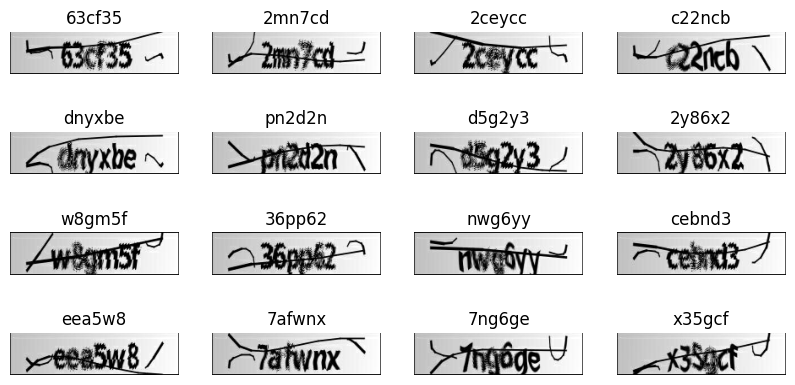

In [9]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


In [11]:
# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [14]:
epochs = 10
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/10
 1/15 [=>............................] - ETA: 1s - loss: 44.2102

InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2442/1104190794.py", line 9, in <module>
      history = model.fit(
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/engine/training.py", line 1232, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2442/1104190794.py", line 9, in <module>
      history = model.fit(
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/anaconda3/2022.10/envs/rk-termin/lib/python3.9/site-packages/keras/engine/training.py", line 1232, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [5], [batch]: [6]
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_7]]
  (1) INVALID_ARGUMENT:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [5], [batch]: [6]
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_13215]